<h1>ZMGSN Lista 4. - Sieci syjamskie</h1>

<h2>Opis zadania</h2>

W ramach zadania należy:
<ol>
<li>Zapoznać się z poniższym eksperymentem z wykorzystaniem sieci dwójkowej</li>
<li>Dokonać analizy wpływu hiperparametrów eksperymentu, np. kroku uczenia, rozmiaru pakietu (ang. <i>batch size</i>), liczby epok na wyniki sieci dwójkowej</li>(10pkt)
<li>Dokonać modyfikacji sieci dwójkowej w celu zbadania wpływu architektury na wyniki</li>(10pkt)
<li>Na podstawie implementacji sieci dwójkowej zaimplementować sieć trójkową. Należy zaimplementować klasę obsługującą zbiór danych, strukturę samej sieci oraz zmodyfikowaną wersję funkcji straty.</li> (30pkt)
<li>Dokonać ewaluacji opracowanej sieci trójkowej zgodnie z punktami 2. i 3.</li>(20pkt)
<li>Porównać jakość działania sieci dwójkowej z jakością działania sieci trójkowej</li>(15pkt)
<li>Opracować procedurę ewaluacji jakości działania sieci dwójkowej i sieci trójkowej, uwzględniającą różne metody wizualizacji (np. wykresy, miary, klasy), klasteryzacji, redukcji wymiarów (np. t-SNE)</li>(15pkt)
</ol>

Ocenie podlegać będzie jakość wykonania zadania, w tym:
<ol>
<li>Właściwe wykonanie zadań</li>
<li>Rzetelne opracowanie wyników, uwzględniające analizę jakościową i ilościową</li>
<li>Opracowanie wniosków mających na celu wyjaśnienie badanych zjawisk i uzyskanych wyników</li>
<li>Opracowanie i wyjaśnienie kodu źródłowego</li>
</ol>


<h2>Import używanych bibliotek</h2>

In [1]:
import random
import PIL.ImageOps

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader, Dataset

<h2>Konfiguracja wyświetlania wizualizacji w bibiliotece Matploltib</h2>

In [2]:
%matplotlib inline

<h2>Inicjalizacja ziarna generatora liczb pseudolosowych</h2>

In [3]:
torch.manual_seed(0)

<h2>Określenie domyślnego urządzenia na podstawie sprawdzenia dostępności karty graficznej</h2>

In [4]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


<h2>Pobranie i rozpakowanie zbioru danych</h2>

In [5]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2023-11-19 23:27:40--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2023-11-19 23:27:41--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip’

at&t.zip            100%[===================>]   3.62M  --.-KB/s    in 0.03s   

2023-11-19 23:27:41 (125 MB/s) - ‘at&t.zip’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   creating: ./

<h2>Funkcje pomocnicze służące do wyświetlania próbek ze zbioru oraz generowania wykresów</h2>

In [6]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

<h2>Deklaracja klasy obsługującej pobrany zbiór danych</h2>

In [7]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        # Potrzebujemy mniej więcej połowę par podobnych obrazków
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                # Wyszukiwanie zdjęcia tej samej osoby
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                # Wyszukiwanie zdjęcia innej  osoby
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

<h2>Wczytanie i wstępne przetwarzanie zbioru danych</h2>

In [8]:
# Wczytanie zbioru danych
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

# Zmiana rozmiaru próbek i konwersja na tensor
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Inicjalizacja klasy obsługującej zbiór danych
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

<h2>Przykładowy podgląd próbek ze zbioru danych</h2>

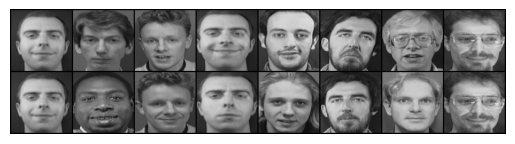

[0. 1. 0. 0. 1. 0. 1. 0.]


In [9]:
# Inicjalizacja klasy obsługującej zbiór danych
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Ekstrakcja pierwszego pakietu danych
example_batch = next(iter(vis_dataloader))

# Pojedynczy pakiet danych zawiera tablicę zdjęć o rozmiarze 2 x 8 oraz etykietę
# Jeżeli etykieta jest równa 1 oznacza to, że para zdjęć nie przedstawia tej samej osoby.
# Jeżeli etykieta jest równa 0 oznacza to, że para zdjęć przedstawia tę samą osobę
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

<h2>Deklaracja podstawowej klasy modelu sieci dwójkowej<h2>

In [10]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # Funkcja zostanie wywołana osobno dla każdej próbki
        # Jej wyjście zostanie wykorzystane w celu określenia odległości
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # Funkcja przyjmuje obie próbki i zwraca parę wektorów
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

<h2>Definicja klasy reprezentującej kontrastową funkcję straty</h2>

In [11]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

<h2></h2>

<h2>Wczytanie zbioru uczącego</h2>

In [12]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<h2>Przykładowa pętla ucząca</h2>

Epoch number 0
 Current loss 1.9355040788650513

Epoch number 1
 Current loss 1.25612473487854

Epoch number 2
 Current loss 0.5884599089622498

Epoch number 3
 Current loss 1.0870063304901123

Epoch number 4
 Current loss 0.8286117315292358

Epoch number 5
 Current loss 0.6209768056869507

Epoch number 6
 Current loss 0.8563123345375061

Epoch number 7
 Current loss 0.664265513420105

Epoch number 8
 Current loss 0.6480986475944519

Epoch number 9
 Current loss 1.104109764099121

Epoch number 10
 Current loss 0.6663983464241028

Epoch number 11
 Current loss 0.6704508066177368

Epoch number 12
 Current loss 0.7153469324111938

Epoch number 13
 Current loss 0.5130994319915771

Epoch number 14
 Current loss 0.6328416466712952

Epoch number 15
 Current loss 0.522601306438446

Epoch number 16
 Current loss 0.5927109718322754

Epoch number 17
 Current loss 0.6133166551589966

Epoch number 18
 Current loss 0.41812533140182495

Epoch number 19
 Current loss 0.40620774030685425

Epoch number 

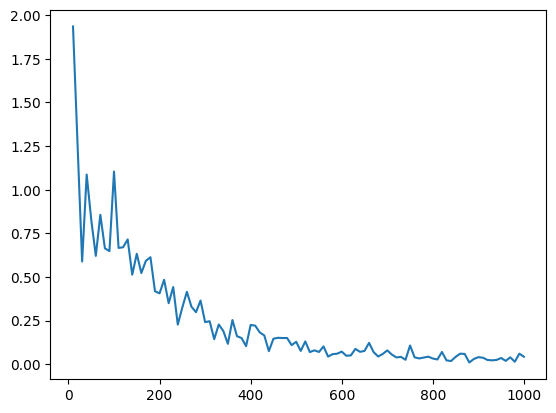

In [13]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

counter = []
loss_history = []
iteration_number= 0

# Iteracja po epokach
for epoch in range(100):

    # iteracja po pakietach
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Przeniesienie obrazów i etykiet do pamięci karty graficznej
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Ustawienie wartości gradientów na zero
        optimizer.zero_grad()

        # Przepuszczenie dwóch obrazów przez sieć i uzyskanie dwóch wektorów wyjściowych
        output1, output2 = net(img0, img1)

        # Obliczenie wartości funkcji straty na podstawie wektorów wyjściowych
        loss_contrastive = criterion(output1, output2, label)

        # Obliczenie zmian wag w oparciu o wartość funkcji straty
        loss_contrastive.backward()

        # Aktualizacja wag sieci
        optimizer.step()

        # Wyświetlenie wartości funkcji straty co 10 pakietów
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

<h2>Przykładowa funkcja służąca do ewaluacji sieci dwójkowej</h2>

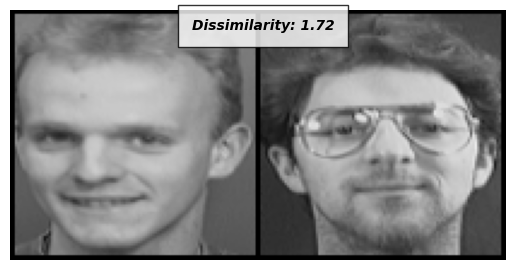

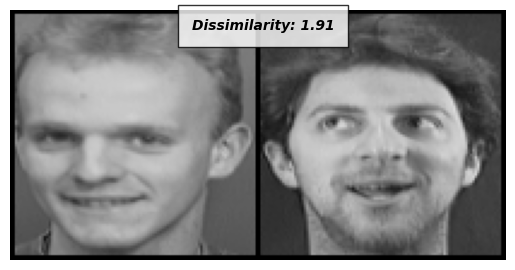

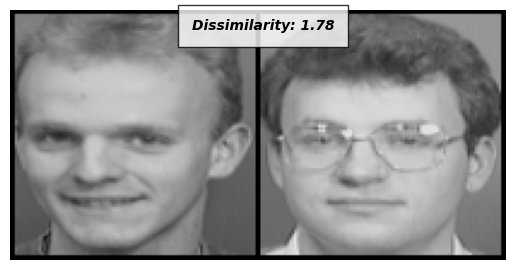

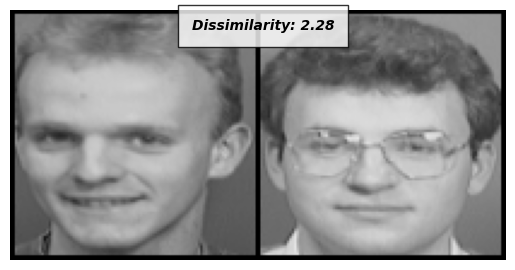

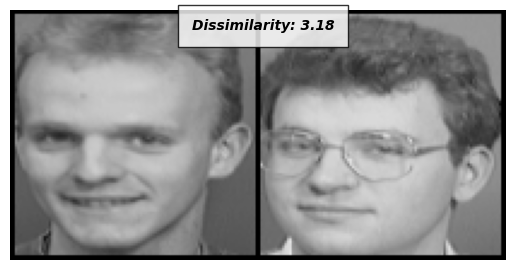

In [14]:
# Określenie ścieżki do katalogu ze zbiorem testowym i wczytanie go do obiektu klasy Dataloader
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Uzyskanie obrazu do przeprowadzenia ewaluacji
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(5):
    # Iteracja po 5 obrazach i sprawdzenie ich podobieństwa z pierwszym obrazem (x0)
    _, x1, label2 = next(dataiter)

    # Konkatenacja dwóch przykładowych obrazów
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')